In [185]:
import pandas as pd
import numpy as np
import os
import random

import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_curve, auc, RocCurveDisplay,  silhouette_score, classification_report, accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_predict, train_test_split
from sklearn.linear_model import LogisticRegression
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.cluster import KMeans

from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")
os.chdir("/Users/yj.noh/Documents/GitHub")
print(os.getcwd())
plt.rcParams['font.family'] = 'AppleGothic'

/Users/yj.noh/Documents/GitHub


## 1. data load

In [186]:
df = pd.read_csv("/Users/yj.noh/Desktop/on_boarding_data.csv", encoding = "cp949")
print(df.head(2))
print(df.isna().sum())

                                       brms_rider_id  birth delivery_method  \
0  44F0CF64B5DD45DFC1DFBBB1A0B81B657378189602F671...   1980    PAS_BICYCLES   
1  D1F1A31D2756936307990C37B252CAA084692082D8C919...   1990            BIKE   

           insurance_type first_available_date business_start_day  is_recom  \
0           ETC_ON_DEMAND           2023-08-15         2023-08-20         1   
1  BIKE_ON_DEMAND_HYUNDAI           2021-03-03         2023-08-02         0   

  gender  day_cnt    avg_cnt last_working_day  outcome  
0    MAN        5   4.400000       2023-08-27        1  
1    MAN        3  12.333333       2023-10-03        0  
brms_rider_id           0
birth                   0
delivery_method         0
insurance_type          0
first_available_date    0
business_start_day      0
is_recom                0
gender                  0
day_cnt                 0
avg_cnt                 0
last_working_day        0
outcome                 0
dtype: int64


In [187]:
#data_filter = df[((df['day_cnt'].notnull()) & (df['delivery_method'] == 'BIKE') & (df['is_recom'] == 0))]
data_filter = df[((df['day_cnt'].notnull()) & (df['delivery_method'] == 'BIKE'))]

#data_filter =  df[df['day_cnt'].notnull()]   

print(data_filter.isna().sum())
print(data_filter.shape) # 3423

brms_rider_id           0
birth                   0
delivery_method         0
insurance_type          0
first_available_date    0
business_start_day      0
is_recom                0
gender                  0
day_cnt                 0
avg_cnt                 0
last_working_day        0
outcome                 0
dtype: int64
(3423, 12)


In [188]:
print(data_filter['outcome'].value_counts()) 

outcome
0    2255
1    1168
Name: count, dtype: int64


# 2. boxplot 

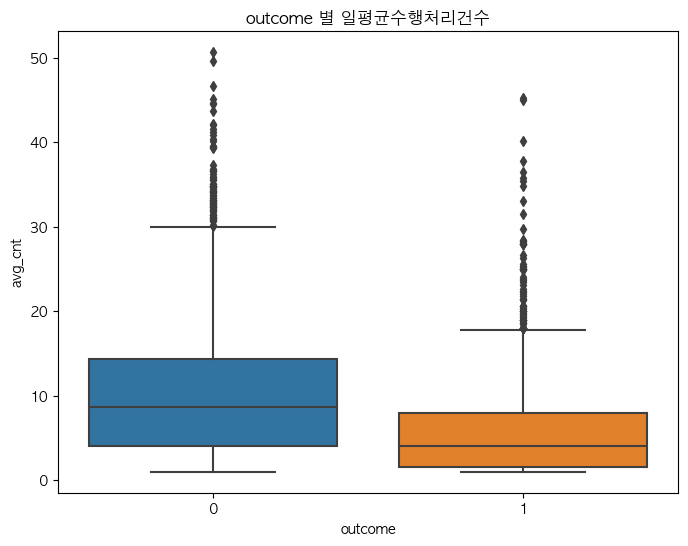

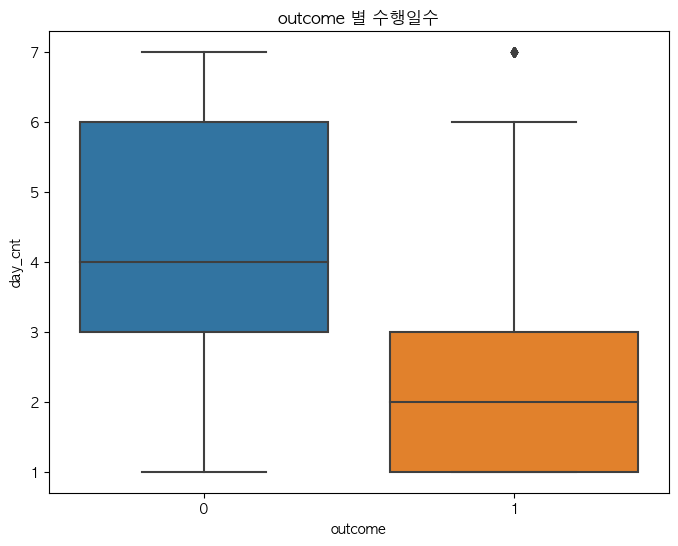

In [189]:
plt.figure(figsize=(8,6))
sns.boxplot(data=data_filter, x='outcome', y='avg_cnt')
plt.title("outcome 별 일평균수행처리건수")
plt.savefig("prj_on_boarding/boxplot1.png")
plt.show()

plt.figure(figsize=(8,6))
sns.boxplot(data=data_filter, x='outcome', y='day_cnt')
plt.title("outcome 별 수행일수")
plt.savefig("prj_on_boarding/boxplot2.png")
plt.show()

In [190]:
# # outlier 제거 
def remove_outliers(df, column):
    Q1 = df.groupby('outcome')[column].quantile(0.25)
    Q3 = df.groupby('outcome')[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return df[df.apply(lambda x: (x[column] >= lower_bound[x['outcome']]) & 
                                 (x[column] <= upper_bound[x['outcome']]), axis=1)]

# 'avg_cnt'와 'day_cnt'에 대한 아웃라이어 제거
data_filtered_avg = remove_outliers(data_filter, 'avg_cnt')
data_filtered_both = remove_outliers(data_filtered_avg, 'day_cnt')

print(data_filtered_both.shape)  #3,257
print(data_filtered_both['outcome'].value_counts())

data_filtered_both.to_excel('prj_on_boarding/data_filtered_both.xlsx', index=False, engine='openpyxl')

(3260, 12)
outcome
0    2181
1    1079
Name: count, dtype: int64


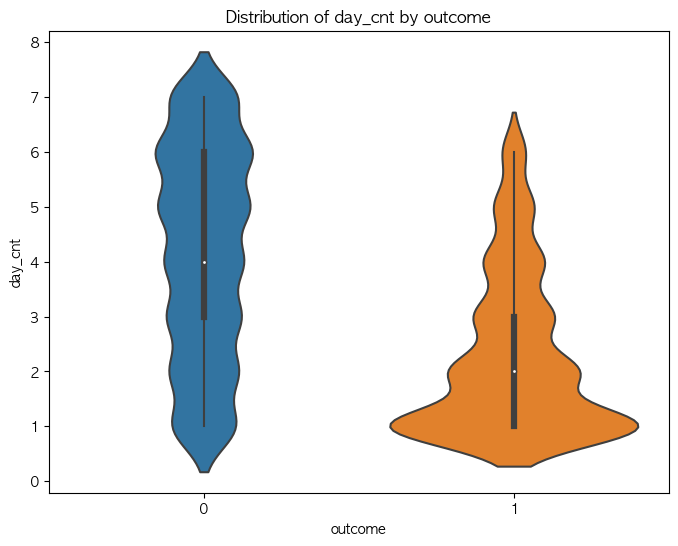

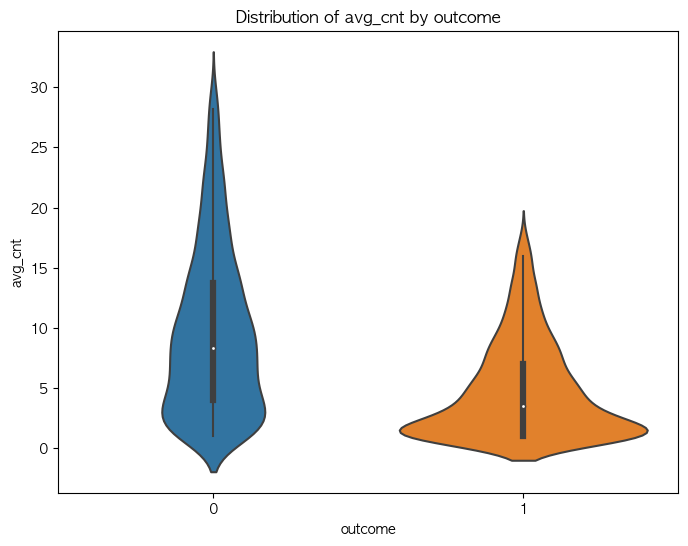

In [191]:
# day_cnt
plt.figure(figsize=(8,6))
sns.violinplot(x='outcome', y='day_cnt', data=data_filtered_both)
plt.title('Distribution of day_cnt by outcome')
plt.show()

# avg_cnt
plt.figure(figsize=(8,6))
sns.violinplot(x='outcome', y='avg_cnt', data=data_filtered_both)
plt.title('Distribution of avg_cnt by outcome')
plt.show()


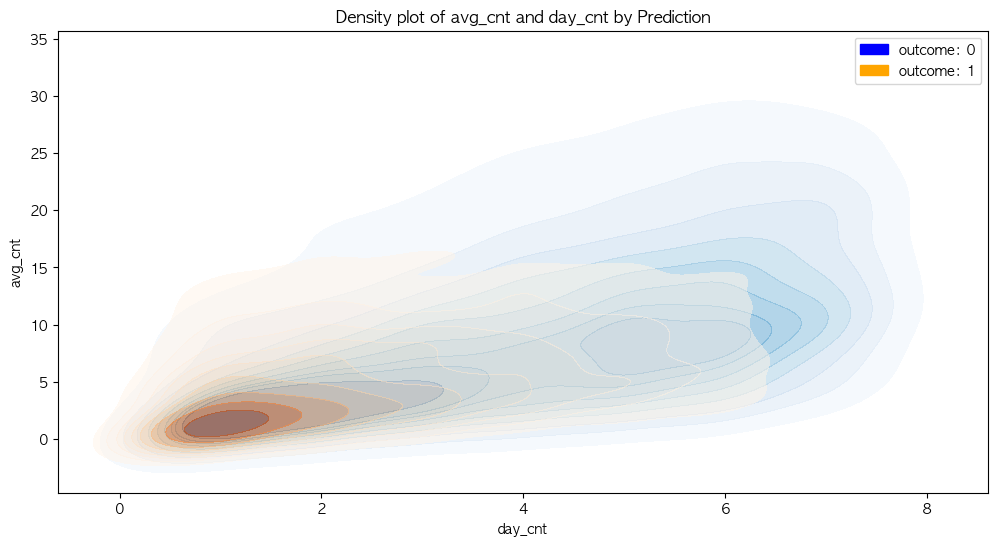

In [192]:
import matplotlib.patches as mpatches

# 데이터 필터링
X_test_0 = data_filtered_both[data_filtered_both['outcome'] == 0]
X_test_1 = data_filtered_both[data_filtered_both['outcome'] == 1]

plt.figure(figsize=(12, 6))

# KDE plot
sns.kdeplot(data=X_test_0, x='day_cnt', y='avg_cnt', cmap='Blues', shade=True, alpha=0.5)
sns.kdeplot(data=X_test_1, x='day_cnt', y='avg_cnt', cmap='Oranges', shade=True, alpha=0.5)

plt.xlabel('day_cnt')
plt.ylabel('avg_cnt')
plt.title('Density plot of avg_cnt and day_cnt by Prediction')

# Manual legend
blue_patch = mpatches.Patch(color='blue', label='outcome: 0')
orange_patch = mpatches.Patch(color='orange', label='outcome: 1')
plt.legend(handles=[blue_patch, orange_patch])
plt.savefig("prj_on_boarding/density plot.png")
plt.show()

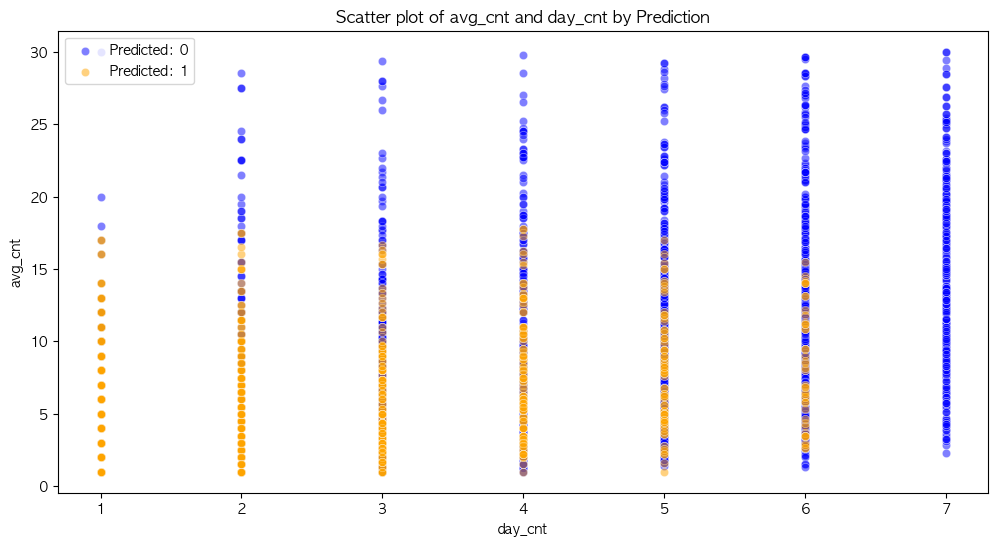

In [193]:
plt.figure(figsize=(12, 6))

# Scatter plot
sns.scatterplot(data=X_test_0, x='day_cnt', y='avg_cnt', color='blue', alpha=0.5, label='Predicted: 0')
sns.scatterplot(data=X_test_1, x='day_cnt', y='avg_cnt', color='orange', alpha=0.5, label='Predicted: 1')

plt.xlabel('day_cnt')
plt.ylabel('avg_cnt')
plt.title('Scatter plot of avg_cnt and day_cnt by Prediction')
plt.legend()
plt.show()


# 3. train, test set split 

In [194]:
train_set, test_set = train_test_split(data_filtered_both, test_size = 0.25, 
                                       stratify = data_filtered_both['outcome'], random_state=1234)
X_train = train_set[['day_cnt', 'avg_cnt']]
y_train = train_set['outcome']
X_test = test_set[['day_cnt', 'avg_cnt']]
y_test = test_set['outcome']

print(X_train.shape, X_test.shape) 
print(y_train. value_counts())
print(y_test.value_counts())

(2445, 2) (815, 2)
outcome
0    1636
1     809
Name: count, dtype: int64
outcome
0    545
1    270
Name: count, dtype: int64


# 4. Decision Tree

Training Accuracy: 0.7170
Test Accuracy: 0.6969


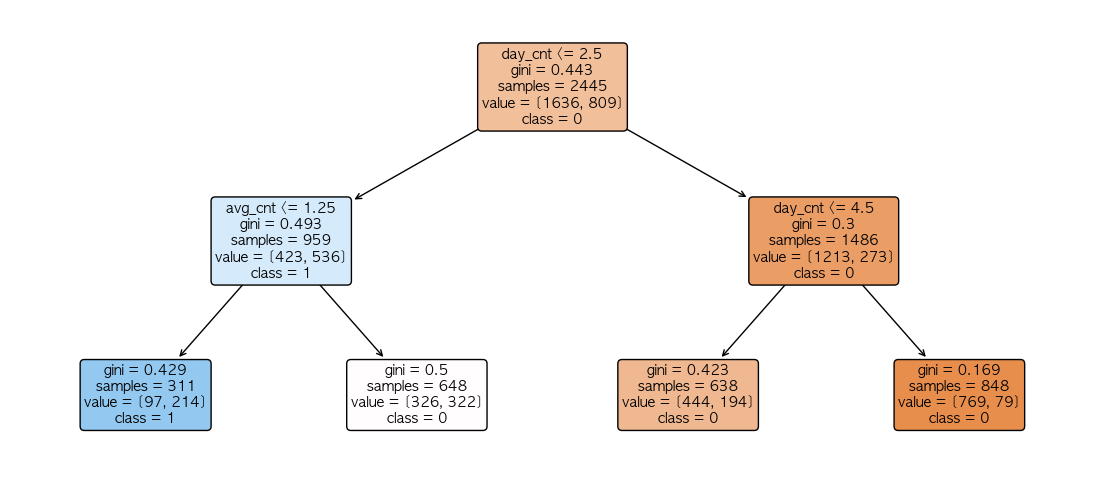

In [203]:
# model 학습
random.seed(2234)
clf = DecisionTreeClassifier(max_depth=2)  
clf = clf.fit(X_train, y_train)

# 모델의 정확도 확인
print(f"Training Accuracy: {clf.score(X_train, y_train):.4f}")
print(f"Test Accuracy: {clf.score(X_test, y_test):.4f}")

# Decision Tree 시각화
fig, ax = plt.subplots(figsize=(14, 6))
tree.plot_tree(clf, filled=True, feature_names=['day_cnt', 'avg_cnt'], class_names=['0', '1'], rounded=True, fontsize=10)
plt.savefig("prj_on_boarding/DT tree.png")
plt.show()



Optimal max_depth is 2
Training Accuracy: 0.7170
Test Accuracy: 0.6969


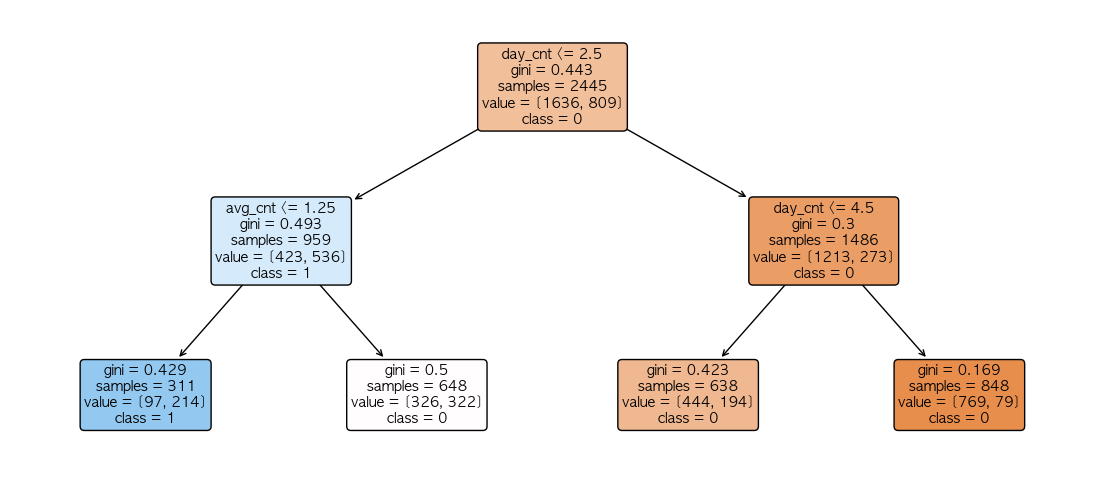

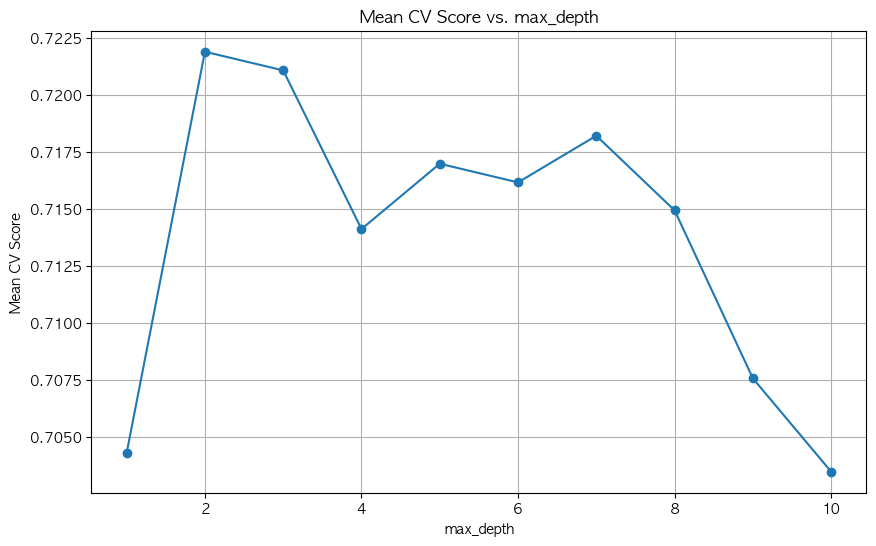

In [205]:
depth_range = list(range(1, 11))  # 예: 1부터 10까지의 깊이를 테스트
cv_scores = []

for depth in depth_range:
    clf = DecisionTreeClassifier(max_depth=depth)
    scores = cross_val_score(clf, X_train, y_train, cv=5)  # 5-fold 교차 검증
    cv_scores.append(scores.mean())

# 교차 검증 점수가 가장 높은 max_depth 값 찾기
optimal_depth = depth_range[cv_scores.index(max(cv_scores))]
print(f"Optimal max_depth is {optimal_depth}")

# 최적의 max_depth 값으로 모델 학습
clf = DecisionTreeClassifier(max_depth=optimal_depth)
clf = clf.fit(X_train, y_train)

# 모델의 정확도 확인
print(f"Training Accuracy: {clf.score(X_train, y_train):.4f}")
print(f"Test Accuracy: {clf.score(X_test, y_test):.4f}")

# Decision Tree 시각화
fig, ax = plt.subplots(figsize=(14, 6))
tree.plot_tree(clf, filled=True, feature_names=['day_cnt', 'avg_cnt'], class_names=['0', '1'], rounded=True, fontsize=10)
plt.savefig("prj_on_boarding/dt tree 1.png")
plt.show()

# 교차 검증 점수에 따른 max_depth 값의 변화를 그래프로 그리기
plt.figure(figsize=(10, 6))
plt.plot(depth_range, cv_scores, marker='o', linestyle='-')
plt.xlabel("max_depth")
plt.ylabel("Mean CV Score")
plt.title("Mean CV Score vs. max_depth")
plt.grid(True)
plt.savefig("prj_on_boarding/cv_dt tree.png")
plt.show()